With the help of this notebook, on can easily change the weights and test different models on custom dataset.

In [1]:
import os
import torch
import numpy as np
import torch.nn.functional as F
from UNetWithResNet34Encoder import UnetResnet34
from SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
import random
from torchvision import transforms

Constants (don't modify)

In [2]:
color2id = {
    (0, 0, 0): 0,          # Unlabeled
    (111, 74, 0): 1,       # Dynamic
    (81, 0, 81): 2,        # Ground
    (128, 64, 128): 3,     # Road
    (244, 35, 232): 4,     # Sidewalk
    (250, 170, 160): 5,    # Parking
    (230, 150, 140): 6,   # Rail track
    (70, 70, 70): 7,      # Building
    (102, 102, 156): 8,   # Wall
    (190, 153, 153): 9,   # Fence
    (180, 165, 180): 10,   # Guard rail
    (150, 100, 100): 11,   # Bridge
    (150, 120, 90): 12,    # Tunnel
    (153, 153, 153): 13,   # Pole
    (153, 153, 153): 14,   # Pole group
    (250, 170, 30): 15,    # Traffic light
    (220, 220, 0): 16,     # Traffic sign
    (107, 142, 35): 17,    # Vegetation
    (152, 251, 152): 18,   # Terrain
    (70, 130, 180): 19,    # Sky
    (220, 20, 60): 20,     # Person
    (255, 0, 0): 21,       # Rider
    (0, 0, 142): 22,       # Car
    (0, 0, 70): 23,        # Truck
    (0, 60, 100): 24,      # Bus
    (0, 0, 90): 25,        # Caravan
    (0, 0, 110): 26,       # Trailer
    (0, 80, 100): 27,      # Train
    (0, 0, 230): 28,       # Motorcycle
    (119, 11, 32): 29      # Bicycle
}

id2color = {
    0: (0, 0, 0),          # Unlabeled
    1: (111, 74, 0),       # Dynamic
    2: (81, 0, 81),        # Ground
    3: (128, 64, 128),     # Road
    4: (244, 35, 232),     # Sidewalk
    5: (250, 170, 160),    # Parking
    6: (230, 150, 140),    # Rail track
    7: (70, 70, 70),       # Building
    8: (102, 102, 156),    # Wall
    9: (190, 153, 153),    # Fence
    10: (180, 165, 180),   # Guard rail
    11: (150, 100, 100),   # Bridge
    12: (150, 120, 90),    # Tunnel
    13: (153, 153, 153),   # Pole
    14: (153, 153, 153),   # Pole group
    15: (250, 170, 30),    # Traffic light
    16: (220, 220, 0),     # Traffic sign
    17: (107, 142, 35),    # Vegetation
    18: (152, 251, 152),   # Terrain
    19: (70, 130, 180),    # Sky
    20: (220, 20, 60),     # Person
    21: (255, 0, 0),       # Rider
    22: (0, 0, 142),       # Car
    23: (0, 0, 70),        # Truck
    24: (0, 60, 100),      # Bus
    25: (0, 0, 90),        # Caravan
    26: (0, 0, 110),       # Trailer
    27: (0, 80, 100),      # Train
    28: (0, 0, 230),       # Motorcycle
    29: (119, 11, 32)      # Bicycle
}

In [3]:
# runName is the name of the model you want to load (without the .pth extension)
runName = "2000mix_baseAugment_ResNet34"

#Path to the dataset
path = "/net/ens/am4ip/datasets/project-dataset"
rainyImagesPath = path + '/rainy_images'
rainySsegPath = path + '/rainy_sseg'

imagesPath = rainyImagesPath
ssegPath = rainySsegPath

#DO NOT CHANGE
modelPath = '/net/cremi/mhajnal/espaces/travail/am4ipProject/DONE/checkpoints/' + runName + '.pth'

In [4]:
def make_predictions(test_dataloader, best_model_path, device='cuda'):
    checkpoint = torch.load(best_model_path)
    
    model = UnetResnet34(output_classes=30)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    pred_masks = []
    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            pred_masks.append(preds.cpu())
    
    return torch.cat(pred_masks, dim=0)

In [5]:
def getImageMaskPairs(imagesDir, ssegDir):
    imageFiles = [f for f in os.listdir(imagesDir) if f.endswith(('.png', '.jpg'))]
    imageFiles.sort()

    imagePaths = []
    maskPaths = []
    for img in imageFiles:
        maskName = os.path.splitext(img)[0] + '.png'
        maskPath = os.path.join(ssegDir, maskName)
        if os.path.exists(maskPath):
            imagePaths.append(os.path.join(imagesDir, img))
            maskPaths.append(maskPath)
        else:
            print(f"Warning: Mask not found for image {img}")
    return imagePaths, maskPaths

In [6]:
testImages, testMasks = getImageMaskPairs(imagesPath, ssegPath)

In [7]:
# If you want random subsampling of the test set, uncomment the following 2 lines
testImages = random.sample(testImages, 50)              # Change the second parameter to the number of images you want to use
testMasks = [testMasks[testImages.index(img)] for img in testImages]

In [8]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Separate transform for masks (no normalization)
mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])



# If you want to use the entire test set, uncomment the following 2 lines
test_dataset = SegmentationDataset(testImages, testMasks, mask_transform=mask_transform, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8)


In [9]:
predictions = make_predictions(test_loader, modelPath)

/tmp/cache-mhajnal/ipykernel_44053/1322600597.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)
/autofs/unityaccount/ens/DeepLearn

Metrics

In [10]:
import segmentation_models_pytorch as smp
def calcIoU(pred_class, masks, num_classes):
    tp, fp, fn, tn = smp.metrics.get_stats(
                output=pred_class.detach().cpu().long(),
                target=masks.cpu(),
                mode="multiclass",
                ignore_index=-1,
                num_classes=num_classes
            )
    batch_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    return batch_iou

def calcMeanIoU(pred_class, masks, num_classes):
    tp, fp, fn, tn = smp.metrics.get_stats(
            output=pred_class.detach().cpu().long(),
            target=masks.cpu(),
            mode="multiclass",
            num_classes=num_classes
        )
        
    # Sum the statistics across all samples in the batch for each class
    tp_sum = tp.sum(dim=0)  # Sum across batch dimension
    fp_sum = fp.sum(dim=0)  # Sum across batch dimension
    fn_sum = fn.sum(dim=0)  # Sum across batch dimension
    
    # Calculate IoU for each class
    class_ious = []
    for class_idx in range(num_classes):
        class_tp = tp_sum[class_idx]
        class_fp = fp_sum[class_idx]
        class_fn = fn_sum[class_idx]
        
        # Check if the class appears in the ground truth or prediction
        denominator = (class_tp + class_fp + class_fn).item()
        if denominator == 0:
            continue
            
        class_iou = (class_tp / (class_tp + class_fp + class_fn + 1e-7)).item()
        class_ious.append(class_iou)
    
    # Return mean over all classes that appear in the image
    return np.mean(class_ious) if class_ious else 0.0

def calcMeanPA(pred, target, num_classes):
    accuracies = []
    for cls in range(num_classes):
        cls_mask = (target == cls)
        if cls_mask.sum() == 0:
            continue
        cls_accuracy = ((pred == cls) & cls_mask).sum().float() / cls_mask.sum()
        accuracies.append(cls_accuracy)
    return torch.stack(accuracies).mean() if accuracies else torch.tensor(0.0).to(pred.device)


In [11]:
testMasks = []

for img,mask in test_loader:
    testMasks.append(mask)

testMasks = torch.cat(testMasks)

In [12]:
testIoU = calcIoU(predictions, testMasks, 30)
testmIoU = calcMeanIoU(predictions, testMasks, 30)
testmPA = calcMeanPA(predictions, testMasks, 30)

print(f"Test IoU: {testIoU:.4f}")
print(f"Test mIoU: {testmIoU:.4f}")
print(f"Test mPA: {testmPA:.4f}")

Test IoU: 0.3519
Test mIoU: 0.0997
Test mPA: 0.1469


Visuals (Can take long for large test sets)

In [13]:
total_mask_output = []

for i,mask_pred in enumerate(predictions):
    height,width = mask_pred.shape
    
    mask_original = testMasks[i]
    ignore = mask_original == -1 # id: -1
    
    mask_predicted = torch.where(ignore, -1, mask_pred)
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_output.append(mask_zeros)

In [14]:
total_mask_test = []

for mask_tst in testMasks:
    height,width = mask_tst.shape
    
    mask_zeros = torch.zeros(size = (height, width, 3), dtype = torch.uint8)
    
    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h,w])
            
            if idcolor in id2color:
                mask_zeros[h,w,:] = torch.tensor(id2color[idcolor])
    
    total_mask_test.append(mask_zeros)

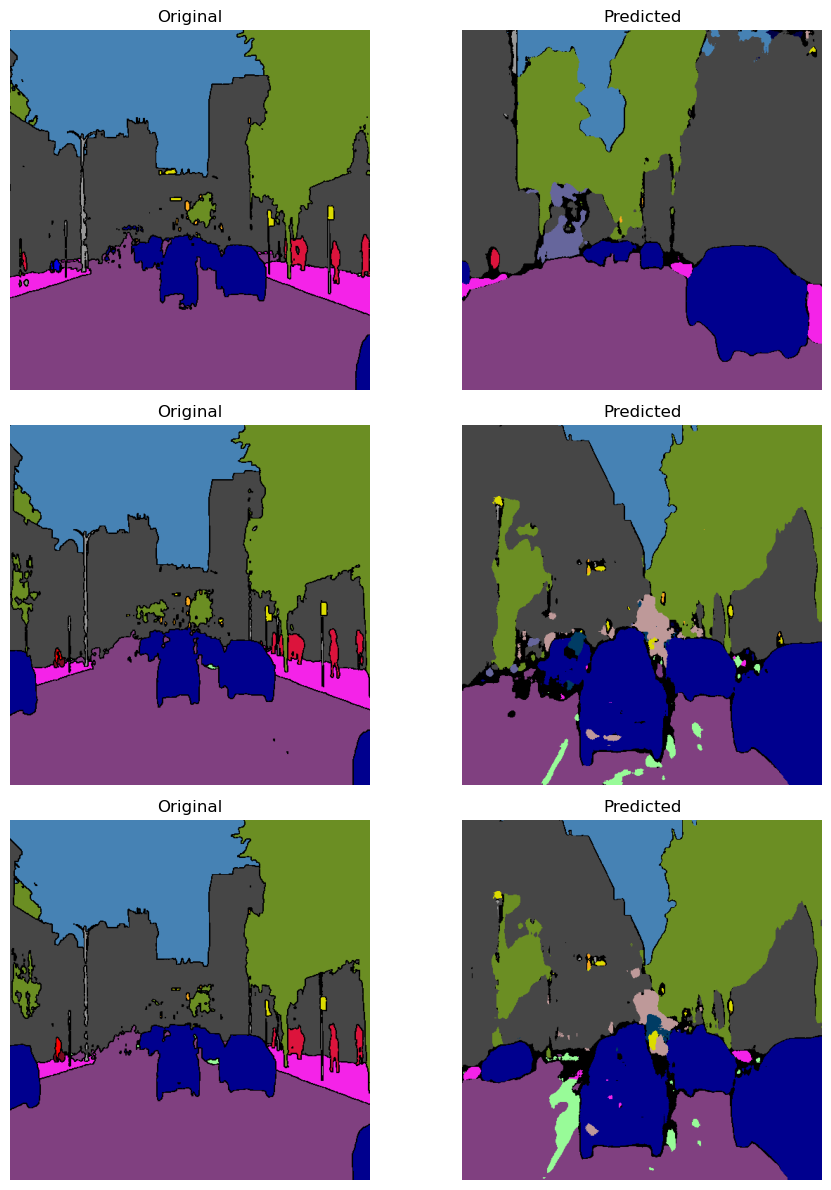

In [16]:
import matplotlib.pyplot as plt
import random

rand_1 = random.randint(1, len(total_mask_test))
rand_2 = random.randint(1, len(total_mask_test))
rand_3 = random.randint(1, len(total_mask_test))


images = [
    total_mask_test[rand_1].numpy(),
    total_mask_output[rand_1].numpy(),
    total_mask_test[rand_2].numpy(),
    total_mask_output[rand_2].numpy(),
    total_mask_test[rand_3].numpy(),
    total_mask_output[rand_3].numpy()
]

titles = [
    "Original",
    "Predicted",
    "Original",
    "Predicted",
    "Original",
    "Predicted"
]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# Flatten the axes array for easy indexing
axes = axes.ravel()

# Plot each image in a separate subplot
for i, ax in enumerate(axes):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis('off')
    else:
        # If you don't have enough images, you can hide extra subplots
        ax.axis('off')

plt.tight_layout()
plt.show()